In [16]:
!pip install pandas
!pip install ripe.atlas.cousteau
!pip install matplotlib
import json
import pandas as pd
from ripe.atlas.cousteau import (
    AtlasResultsRequest
)
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np


170723.46s - pydevd: Sending message related to process being replaced timed-out after 5 seconds



[notice] A new release of pip available: 22.2.2 -> 23.2.1
[notice] To update, run: pip install --upgrade pip


170736.18s - pydevd: Sending message related to process being replaced timed-out after 5 seconds



[notice] A new release of pip available: 22.2.2 -> 23.2.1
[notice] To update, run: pip install --upgrade pip


170745.42s - pydevd: Sending message related to process being replaced timed-out after 5 seconds



[notice] A new release of pip available: 22.2.2 -> 23.2.1
[notice] To update, run: pip install --upgrade pip


In [17]:
pd.options.display.max_columns = None #make sure all columns are displayed
pd.options.display.max_colwidth = None
pd.options.display.max_rows = None


/var/folders/j0/dqmhv9s17ys57ml7jn321p6c0000gn/T/ipykernel_50889/3831324522.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['icmp_replies'][x] = pd.json_normalize(df1['icmp_replies'][x])
/var/folders/j0/dqmhv9s17ys57ml7jn321p6c0000gn/T/ipykernel_50889/3831324522.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['icmp_replies'][x] = pd.json_normalize(df1['icmp_replies'][x])
/var/folders/j0/dqmhv9s17ys57ml7jn321p6c0000gn/T/ipykernel_50889/3831324522.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata

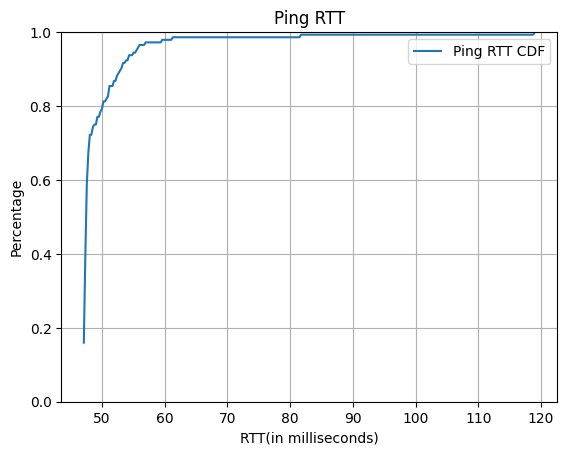

In [18]:
#basic ping from Fall 2022 Semester; will not be used for paper
#works

with open('pingTest9-17pmOct200.json', 'r') as f:
    data = json.loads(f.read())
df1 = pd.DataFrame(data)

just_rtt = []
for x, row in df1.iterrows():
    df1['icmp_replies'][x] = pd.json_normalize(df1['icmp_replies'][x])
    for result in df1['icmp_replies'][x]:
        just_rtt.append(df1['icmp_replies'][x]['time'])

data = np.array(just_rtt)
count, bins_count = np.histogram(data, bins=300)
pdf = count / sum(count)
cdf = np.cumsum(pdf)
plt.plot(bins_count[1:], cdf, label="Ping RTT CDF")
plt.ylim([0, 1.0])
plt.title('Ping RTT')
plt.ylabel('Percentage')
plt.xlabel('RTT(in milliseconds)')
plt.grid()
plt.legend()




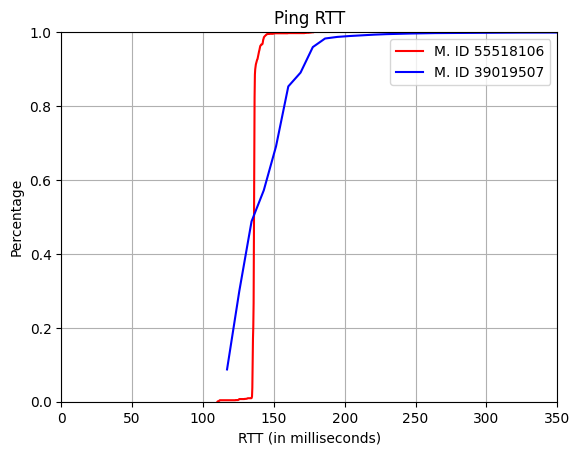

In [19]:
#Ping RTT CDF RIPE Atlas
#works

# List of measurement IDs
measurement_ids = [55518106, 39019507]  # Add your desired measurement IDs here

# List of colors for each measurement ID
colors = ['red', 'blue', 'green', 'purple', 'black']  # Add your desired colors here

# Iterate over each measurement ID
for idx, measurement_id in enumerate(measurement_ids):
    kwargs = {
        "msm_id": measurement_id
    }

    is_success, results = AtlasResultsRequest(**kwargs).create()

    if is_success:
        # Extract RTT values from the results
        rtt_values = []
        for result in results:
            if "result" in result:
                for rtt_result in result["result"]:
                    if "rtt" in rtt_result:
                        rtt_values.append(rtt_result["rtt"])
                    else:
                        rtt_values.append(None)  # Append None for missing RTT values

        # Filter out None values
        rtt_values = [rtt for rtt in rtt_values if rtt is not None]

        # Create array with RTT values
        data = np.array(rtt_values)

        # Create histogram
        count, bins_count = np.histogram(data, bins=300)

        # Calculate PDF and CDF
        pdf = count / sum(count)
        cdf = np.cumsum(pdf)

        # Plot CDF with specified color
        plt.plot(bins_count[1:], cdf, label=f"M. ID {measurement_id}", color=colors[idx])

# Set x-axis limit to the highest RTT value across all measurement IDs
max_rtt = max(data)
plt.xlim([0, 350])

# Set y-axis limits
plt.ylim([0, 1.0])



plt.title('Ping RTT')
plt.ylabel('Percentage')
plt.xlabel('RTT (in milliseconds)')
plt.grid()
plt.legend()
plt.show()


   


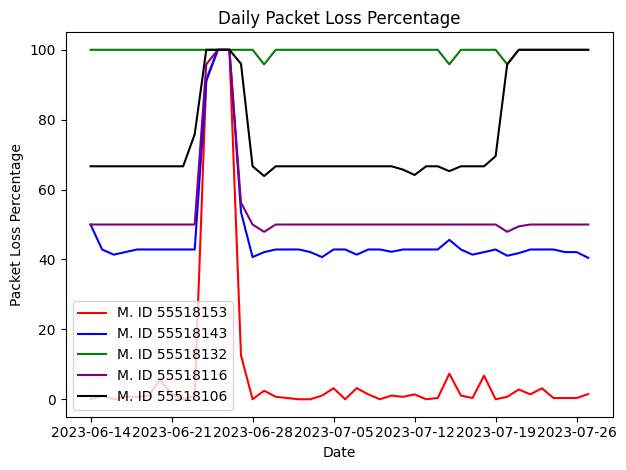

In [20]:
#RIPE Atlas Packet Loss Percentage Graph
#Might transform to cdf, might not
#Shows percent of packets lost per day, could be changed to hours, months, weeks, etc.
#works

import json
import pandas as pd
import matplotlib.pyplot as plt

measurement_ids = [55518153, 55518143, 55518132, 55518116, 55518106]  # Add your desired measurement IDs here
#measurement_ids = [55518153, 39019539]

# List of colors for each measurement ID
colors = ['red', 'blue', 'green', 'purple', 'black']  # Add your desired colors here

# Create an empty DataFrame to store the combined data
combined_data = pd.DataFrame()

# Iterate over each measurement ID
for idx, measurement_id in enumerate(measurement_ids):
    kwargs = {
        "msm_id": measurement_id
    }

    is_success, results = AtlasResultsRequest(**kwargs).create()

    if is_success:
        timestamps = []
        packet_loss = []
        sent = []
        
        for row in results:
            timestamps.append(pd.to_datetime(row['timestamp'], unit='s').date())
            packet_loss.append(row['sent'] - row['rcvd'])
            sent.append(row['sent'])
        
        # Create a DataFrame with timestamps and packet loss
        data = pd.DataFrame({'timestamp': timestamps, 'packet_loss': packet_loss, 'sent': sent})
        
        # Group by date and calculate the percentage packet loss
        daily_packet_loss = data.groupby('timestamp')['packet_loss'].sum()
        total_packets_sent = data.groupby('timestamp')['sent'].sum()
        daily_packet_loss_percentage = daily_packet_loss / total_packets_sent * 100
        
        # Add the data to the combined DataFrame
        combined_data = pd.concat([combined_data, daily_packet_loss_percentage], axis=1)
        
        # Plotting the packet loss over time for each measurement ID
        plt.plot(daily_packet_loss_percentage.index, daily_packet_loss_percentage.values, label=f"M. ID {measurement_id}", color=colors[idx])

plt.xlabel('Date')
plt.ylabel('Packet Loss Percentage')
plt.title('Daily Packet Loss Percentage')

# Specify the interval for x-axis labels (e.g., display every 7th label)
x_ticks_interval = 7
plt.xticks(combined_data.index[::x_ticks_interval])

plt.legend()  # Add a legend to distinguish measurement IDs
plt.tight_layout()  # Adjust plot layout for better spacing
plt.show()



/var/folders/j0/dqmhv9s17ys57ml7jn321p6c0000gn/T/ipykernel_50889/3705748771.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['result'][x] = pd.json_normalize(df1['result'][x])
/var/folders/j0/dqmhv9s17ys57ml7jn321p6c0000gn/T/ipykernel_50889/3705748771.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['result'][x] = pd.json_normalize(df1['result'][x])
/var/folders/j0/dqmhv9s17ys57ml7jn321p6c0000gn/T/ipykernel_50889/3705748771.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

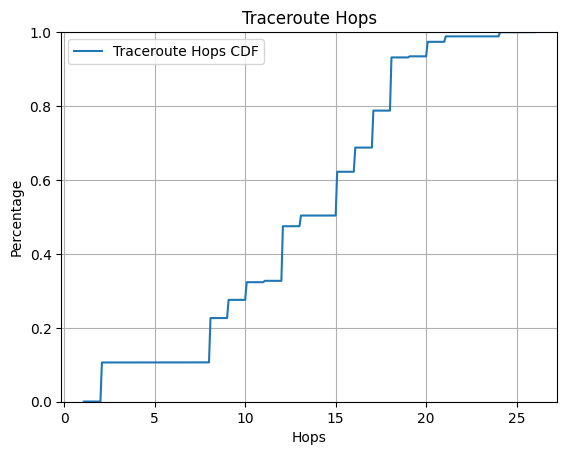

In [21]:
#FIX THIS GRAPH TO START AT ZERO

#Traceroute Hops CDF RIPE Atlas
#works
kwargs = {
    "msm_id": 40016357
}

is_success, results = AtlasResultsRequest(**kwargs).create()

if is_success:
    #print the json string
    #print(results)

    #CREATE A DATAFRAME WITH THE ENTIRETY OF THE MEASUREMENT RESULTS
    df1 = pd.json_normalize(results)

    #CREATE hops VARIABLE AND INITIALIZE TO ZERO
    hops = 0

    #CREATE EMPTY LIST hops_per_run
    hops_per_run = []
    #display(df1)
    
    #FOR EACH ROW IN DF1
    for x, row in df1.iterrows():
        
        #NORMALIZE THE RESULTS
        df1['result'][x] = pd.json_normalize(df1['result'][x])

        #FOR EACH HOP IN THE ROW
        for hop, row in df1['result'][x].iterrows():

            #INCREMENT hops
            hops = hops + 1
            #has attribute
            
        #APPEND hops TO hops_per_run, hops IS EQUAL TO THE NUMBER OF HOPS IN A SINGLE ROW
        hops_per_run.append(hops)
    
        #SET hops TO ZERO SO THAT EACH LOOP WILL PRODUCE THE CORRECT NUMBER OF HOPS IN A ROW
        hops = 0
    
    #print(hops_per_run)

#SET DATA TO hops_per_run     
data = np.array(hops_per_run)

#CREATE HISTOGRAM
count, bins_count = np.histogram(data, bins=300)

#CALCULATE PDF
pdf = count / sum(count)

#CALCULATE CDF
cdf = np.cumsum(pdf)


#plt.plot(bins_count[1:], pdf, color="red", label="PDF")

#PLOT CDF
plt.plot(bins_count[1:], cdf, label="Traceroute Hops CDF")
plt.ylim([0,1.0])
plt.title('Traceroute Hops')
plt.ylabel('Percentage')
plt.xlabel('Hops')
plt.grid()
plt.legend()

#ALTHOUGH BINS=300 IN THIS CELL, THE GRAPH WILL NEVER START AT 0 PERCENT DUE TO THE DATA IT CONTAINS
            

/var/folders/j0/dqmhv9s17ys57ml7jn321p6c0000gn/T/ipykernel_50889/2522886330.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['result'][x] = pd.json_normalize(df1['result'][x])
/var/folders/j0/dqmhv9s17ys57ml7jn321p6c0000gn/T/ipykernel_50889/2522886330.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['result'][x] = pd.json_normalize(df1['result'][x])
/var/folders/j0/dqmhv9s17ys57ml7jn321p6c0000gn/T/ipykernel_50889/2522886330.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

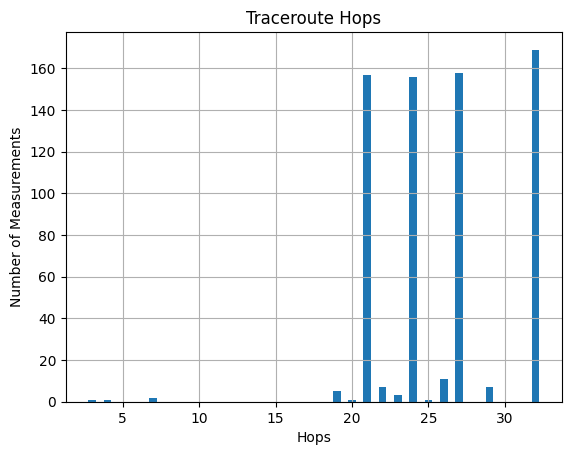

In [22]:
#Traceroute Hops BAR GRAPH RIPE Atlas
#works
kwargs = {
    "msm_id": 55518080
}

is_success, results = AtlasResultsRequest(**kwargs).create()

if is_success:
    #print the json string
    #print(results)

    #CREATE A DATAFRAME WITH THE ENTIRETY OF THE MEASUREMENT RESULTS
    df1 = pd.json_normalize(results)

    #CREATE hops VARIABLE AND INITIALIZE TO ZERO
    hops = 0

    #CREATE EMPTY LIST hops_per_run
    hops_per_run = []
    #display(df1)
    
    #FOR EACH ROW IN DF1
    for x, row in df1.iterrows():
        
        #NORMALIZE THE RESULTS
        df1['result'][x] = pd.json_normalize(df1['result'][x])

        #FOR EACH HOP IN THE ROW
        for hop, row in df1['result'][x].iterrows():

            #INCREMENT hops
            hops = hops + 1
            #has attribute
            
        #APPEND hops TO hops_per_run, hops IS EQUAL TO THE NUMBER OF HOPS IN A SINGLE ROW
        hops_per_run.append(hops)
    
        #SET hops TO ZERO SO THAT EACH LOOP WILL PRODUCE THE CORRECT NUMBER OF HOPS IN A ROW
        hops = 0
    
#CREATE count_num TO KEEP TRACK OF NUMBER OCCURENCES
count_num = 0

#CREATE unique_num LIST
unique_num = []

#CREATE num_occurence LIST
num_occurence = []

#FOR EACH item IN hops_per_run
for item in hops_per_run:
    #IF THE ITEM IS NOT IN THE unique_num LIST, ADD IT
    if item not in unique_num:
            unique_num.append(item)
#WE NOW HAVE A LIST OF ALL THE UNIQUE NUMBERS OF HOPS

#print(unique_num)

#FOR EACH i IN unique_num
for i in unique_num:
    #print(i)
    #FOR EACH item IN hops_per_run
    for item in hops_per_run:
        #IF THE item IS EQUAL TO i THEN INCREMENT count_num
        if item == i:
            count_num = count_num + 1
    #APPEND count_num TO num_occurence
    num_occurence.append(count_num)
    #print(count_num)
    #RESET count_num
    count_num = 0
#WE NOW HAVE A LIST OF THE NUMBER OF OCCURENCES OF EACH UNIQUE NUMBER OF HOPS

#print(num_occurence)


plt.bar(x = unique_num, height = num_occurence, width = 0.5)
plt.title('Traceroute Hops')
plt.ylabel('Number of Measurements')
plt.xlabel('Hops')
plt.grid()


In [23]:
#Traceroute RTT and Traceroute Hops RIPE Atlas
#partially working
import math
kwargs = {
    "msm_id": 55518080
}

is_success, results = AtlasResultsRequest(**kwargs).create()

if is_success:

    #CREATE A DATAFRAME WITH THE ENTIRETY OF THE MEASUREMENT RESULTS
    df1 = pd.json_normalize(results)

    rtt_within_hop = 0              #where we will add the 0-3 rtt results for each individual hop
    rtt_within_hop_count = 0        #to keep track of how many rtt results are in each hop
    average_rtt = 0                 #for the average rtt within each hop
    total_rtt_one_measurement = 0   #to add all of the hop averages to find overall rtt within one traceroute measurement

    traceroutes_hops = []           #all the hops for every traceroute
    hops_results = []               #need a 2D list so that measurements are not mixed together ask for help in writing this.
    hop_result2 = []                #holds average rtts per hop
    count = 0                       #count measurements
    count2 = 0                      #count hops
  

    for trace in df1['result']:     #for each measurement
        traceroutes_hops.append(pd.json_normalize(trace)) 

        for hop in traceroutes_hops[count]['result']:   #for each hop
            hops_results.append(pd.json_normalize(hop))
            
            count2+=1
        count+=1
      

    for x in hops_results:                                                     #for each hop

        #research iperf

        if hasattr(x,'rtt'):                                                #if the hop has an rtt column

            if hasattr(x,'x') == False or (x['x'][0] == '*') == False:      #if it doesn't have an x column or if the x column is not equal to *
                rtt_within_hop = rtt_within_hop + x['rtt'][0]               #add the rtt to the rtt_within_hop variable
                rtt_within_hop_count = rtt_within_hop_count + 1             #increment count
            if hasattr(x,'x') == False or (x['x'][1] == '*') == False:
                rtt_within_hop = rtt_within_hop + x['rtt'][1]
                rtt_within_hop_count = rtt_within_hop_count + 1
            if hasattr(x,'x') == False or (x['x'][2] == '*') == False:
                rtt_within_hop = rtt_within_hop + x['rtt'][2]
                rtt_within_hop_count = rtt_within_hop_count + 1

        if rtt_within_hop_count == 0:                                       #if the count is zero then set average_rtt to * (so that it is easy to find
            average_rtt = '*'                                               #the measurements that did not complete later in the process and to avoid errors)
        else:
            average_rtt = rtt_within_hop / rtt_within_hop_count             #if count is not zero then calculate the rtt average

        hop_result2.append(average_rtt)                                     #append the averages to a list hop_result2

        rtt_within_hop = 0                                                  #reset rtt_within_hop, rtt_within_hop_count, and average_rtt to zero
        rtt_within_hop_count = 0
        average_rtt = 0



    hops = 0                    #keeps track of hop number
    hops_per_run = []           #list to hold the hop numbers
    start = 0                   #needed for range
    stop = 0                    #needed for range
    total_rtt_all_measurements = []     #list to hold the total rtts for each measurement
    count_m = 0                 #keeps track of how many measurements you have gone through (not really needed)
    count_star = 0              #keeps track of stars encountered (not really needed)
    

    for x, row in df1.iterrows():                                           #for each row in df1
        
        df1['result'][x] = pd.json_normalize(df1['result'][x])              #normalize the results

        for hop, row in df1['result'][x].iterrows():                        #for each hop in a single row

            hops = hops + 1                                                 #increment hops
            
        hops_per_run.append(hops)                                           #append hops to hops_per_run, hops is equal to the number of hops in a single row (measurement)
    
        hops = 0                                                            #set hops to zero so that each loop will produce the correct number of hops per row
    
    
    for i in hops_per_run:                                                  #for each number in hops_per_run
        stop = stop + i                                                     #stop increments by i so that we can coordinate the range with the order of hop numbers in hops_per_run
        for avg in range (start, stop):                                     #for each rtt in the range
            if hop_result2[avg] == '*':                                     #if a star replaces any rtt within the range
                count_star += 1                                             #increment count_star
                total_rtt_one_measurement = '*'                             #the total_rtt_one measurement is set to * (we cannot include it in the set)
                break                                                       #and the loop is broken for that range
            total_rtt_one_measurement = total_rtt_one_measurement + hop_result2[avg]    #we add all of the rtts within range to calculate the total rtt for a single measurement
        
        total_rtt_all_measurements.append(total_rtt_one_measurement)        #add the totals to total_rtt_all_measurements
        count_m += 1                                                        #increment count_m (because the rtt of one measurement of i hops has been calculated)
        total_rtt_one_measurement = 0                                       #reset total_rtt_one_measurement to zero
        start = stop                                                        #start = stop so that we can collect data accurately
    

    unique_num = []                         #this list will hold all of the unique hop counts
    total_hop_occurence = 0                 #keeps track of hop count occurence
    collective_rtt = 0                      #keeps track of collective rtt of a specific hop count
    average_rtt_of_hop = 0                  #keeps track of average rtt of a measurement with i number of hops
    all_averages = []                       #holds all of the rtt averages
    finished_hop_num = []                   #holds the hop counts of measurements that finished
    finished_hop_count = []                 #holds the occurence of measurements that finished
    data_for_stddev = []                    #will hold the rtts temporarily to calculate standard deviation
    stddev = 0
    std_for_hop = []


    for item in hops_per_run:                                               #for each item in hops_per_run
        if item not in unique_num:                                          #if the item is not in unique_num, it is added
                unique_num.append(item)

    for item in unique_num:                                                 #for each item in unique_num
        for i in range(0, len(hops_per_run)):                               #for each index within the length of hops_per_run
            if hops_per_run[i] == item:                                     #if hops_per_run at that index is equal to the item in unique_num
                if total_rtt_all_measurements[i] != '*':                    #if the rtt at index i of total_rtt_all_measurements is not a * (* means the measurement did not complete)
                    total_hop_occurence += 1                                #increment total_hop_occurence
                    collective_rtt += total_rtt_all_measurements[i]         #add the rtt to collective_rtt
                    data_for_stddev.append(total_rtt_all_measurements[i])

        if total_hop_occurence != 0:                                        #if total_hop_occurence is not zero
            average_rtt_of_hop = collective_rtt / total_hop_occurence       #calculate the average rtt of hop count "item"
            finished_hop_num.append(item)                                   #append hop count "item" to finished_hop_num
            finished_hop_count.append(total_hop_occurence)                  #append the total_hop_occurence to finished_hop_count
        else:
            average_rtt_of_hop = '*'                                        #if total_hop_occurence is zero, the average rtt of the hop count "item" is set to *
        if average_rtt_of_hop != '*':                                       #if the average_rtt_of_hop is not a * (measurements were completed), append to all_averages
            all_averages.append(average_rtt_of_hop)
        total_hop_occurence = 0                                             #reset total_hop_occurence and collective_rtt to zero
        collective_rtt = 0

        stddev = np.std(data_for_stddev)
        if math.isnan(stddev) == False:
            std_for_hop.append(stddev)
        data_for_stddev.clear()

    
    # zip_object = zip(unique_num, all_averages)
    # display(list(zip_object))
    # zip_object = zip(finished_hop_num, finished_hop_count)
    # display(list(zip_object))

plt.bar(x = finished_hop_num, height = all_averages, width = 1, yerr = std_for_hop, align='center', alpha=0.5, capsize=10)
plt.title('Traceroute RTT')
plt.ylabel('Round Trip Time (milliseconds)')
plt.xlabel('Hops')
plt.grid()
plt.show()

plt.bar(x = finished_hop_num, height = finished_hop_count, width = 1)
plt.title('Traceroute Hop Occurence')
plt.ylabel('Number of Measurements')
plt.xlabel('Hops')
plt.grid()
plt.show()

#combine traceroute hops cell into this cell because we already have access to which measurements completed so we can add a count var within
#the for loop to capture the occurences of completed measurements per hop count and append to a list then graph both inside of one cell :)









    
    


    
        


KeyError: 2

/var/folders/j0/dqmhv9s17ys57ml7jn321p6c0000gn/T/ipykernel_50889/932737967.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['icmp_replies'][x] = pd.json_normalize(df1['icmp_replies'][x])
/var/folders/j0/dqmhv9s17ys57ml7jn321p6c0000gn/T/ipykernel_50889/932737967.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['icmp_replies'][x] = pd.json_normalize(df1['icmp_replies'][x])
/var/folders/j0/dqmhv9s17ys57ml7jn321p6c0000gn/T/ipykernel_50889/932737967.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/p

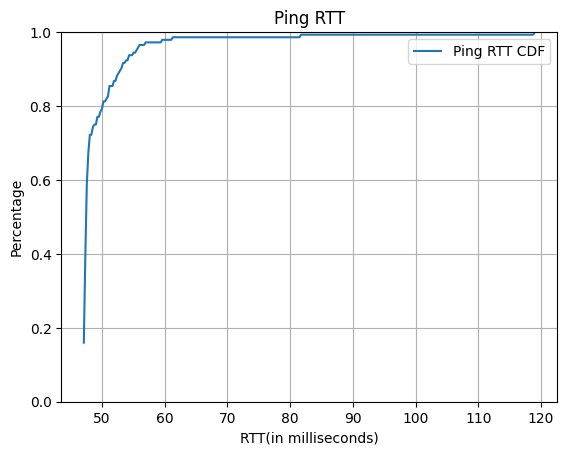

In [24]:
#Ping RTT (Leo Data) - single measurement
#works
with open('pingTest9-17pmOct200.json', 'r') as f:
    data = json.loads(f.read())
df1 = pd.DataFrame(data)

rtt = []
for x, row in df1.iterrows():
    df1['icmp_replies'][x] = pd.json_normalize(df1['icmp_replies'][x])
    for result in df1['icmp_replies'][x]:
        rtt.append(df1['icmp_replies'][x]['time'])

data = np.array(rtt)
count, bins_count = np.histogram(data, bins=300)
pdf = count / np.sum(count)
cdf = np.cumsum(pdf)
plt.plot(bins_count[1:], cdf, label="Ping RTT CDF")
plt.ylim([0, 1.0])
plt.title('Ping RTT')
plt.ylabel('Percentage')
plt.xlabel('RTT(in milliseconds)')
plt.grid()
plt.legend()

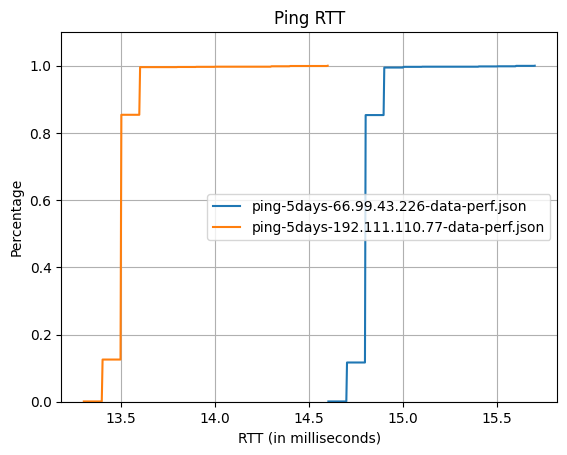

In [25]:
#Command-Line Ping RTT CDF
#works

import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def plot_ping_rtt(files):
    for file_path in files:
        # Read the JSON file
        with open(file_path, 'r') as f:
            data = json.load(f)

        # Create a DataFrame from the JSON data
        df1 = pd.DataFrame(data)

        # Extract RTT values
        rtt = []
        for x, row in df1.iterrows():
            transmissions = df1['ping_data'][x]
            for transmission in transmissions:
                rtt.append(transmission['time'])

        # Convert RTT to numpy array
        data = np.array(rtt)

        # Compute histogram
        count, bins_count = np.histogram(data, bins=300)
        pdf = count / np.sum(count)
        cdf = np.cumsum(pdf)

        # Plot CDF
        plt.plot(bins_count[1:], cdf, label=file_path)

    plt.ylim([0, 1.1])
    plt.title('Ping RTT')
    plt.ylabel('Percentage')
    plt.xlabel('RTT (in milliseconds)')
    plt.grid()
    plt.legend()
    plt.show()

# List of file paths
#files = ['ping_data_66.json', 'ping_data_206.json', 'ping_data_192.json']  # Replace with the actual file paths
#files = ['ping-5days-192.111.110.77-data-leo.json', 'ping-5days-206.71.76.62-data-perf.json', 'ping-5days-206.71.76.62-data-leo.json', 'ping-5days-66.99.43.226-data-perf.json','ping-5days-66.99.43.226-data-leo.json','ping-5days-192.111.110.77-data-perf.json' ]
files = ['ping-5days-66.99.43.226-data-perf.json', 'ping-5days-192.111.110.77-data-perf.json']

# Plot Ping RTT for each file
plot_ping_rtt(files)


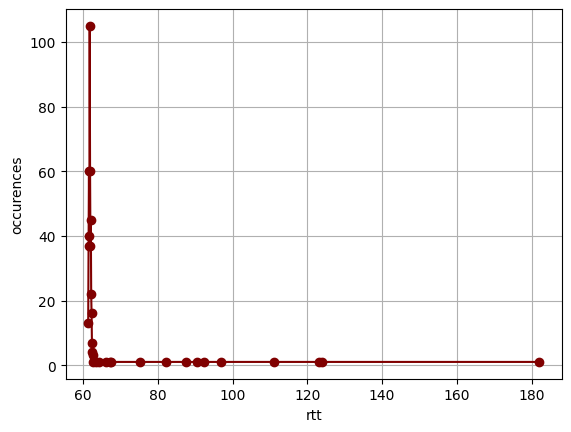

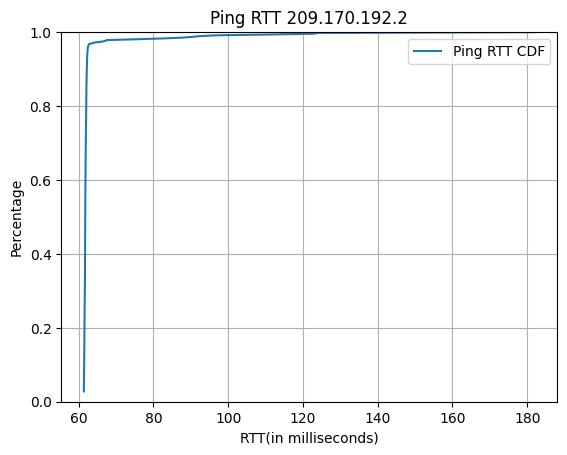

In [26]:
#Ping RTT (PerfSONAR) - single measurement 
#works

with open('example2.json', 'r') as f:
    data = json.loads(f.read())

d1 = data["val"]                                #section off values section of aggregation file
d1 = {float(k):v for (k,v) in d1.items()}       #convert keys to floats
d1 = dict(sorted(d1.items()))                   #sort d1 by keys (rtt)

xAxis = [key for key, value in d1.items()]      #rtt
yAxis = [value for key, value in d1.items()]    #occurences
plt.grid(True)
plt.plot(xAxis,yAxis, color='maroon', marker='o')
plt.xlabel('rtt')
plt.ylabel('occurences')

plt.show()

count = np.array(yAxis)
bins_count = np.array(xAxis)

pdf = count / np.sum(count)
cdf = np.cumsum(pdf)

plt.plot(bins_count[0:], cdf, label="Ping RTT CDF")
plt.ylim([0, 1.0])
plt.title('Ping RTT ' + data["ip"])
plt.ylabel('Percentage')
plt.xlabel('RTT(in milliseconds)')
plt.grid()
plt.legend()


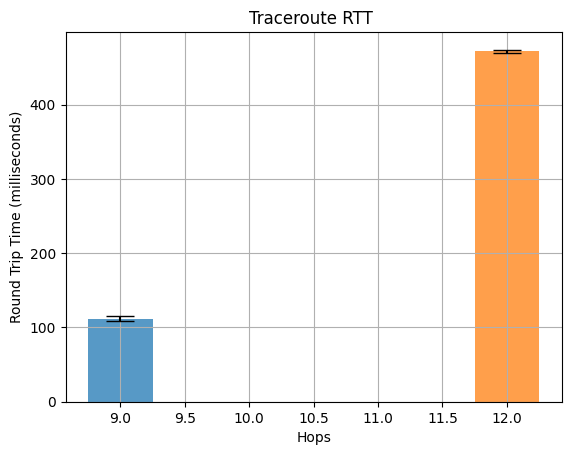

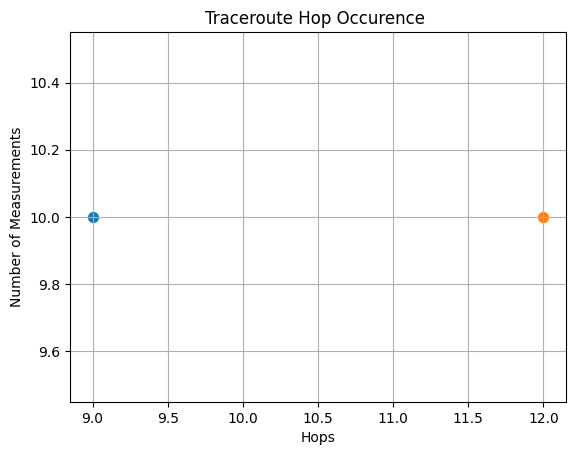

In [27]:
#Traceroute Hops perfSONAR
import math
files = ['192_10hr.json', '209_10hr.json']
#files = ['216_10hr.json', '207_10hr.json']
#files = ['136_10hr.json', '67_10hr.json', '141_10hr.json', '66_10hr.json', '206_10hr.json']

for file in files:
    with open(file, 'r') as f:
        data = json.loads(f.read())

    data_points = 0
    hops = 0
    total_hop_occurence = 0
    hop_rtt = 0 
    total_rtt = 0
    average_rtt = 0
    stddev = 0
    collective_rtt = 0
    ttl = 0
    dest = ''


    total_hops = []
    unique_num = []
    finished_hop_num = []
    finished_hop_count = []
    total_averages = []
    total_rtts = []
    std_for_hop = []


    for i in data:
        data_points = data_points + 1
        for item in data[data_points - 1]['val']:
            ttl += 1                                                    #keep track of attempted hops
            if 'rtt' in item:                                           #only sums the completed hops
                hops = hops + 1
                hop_rtt = item['rtt']
                total_rtt += hop_rtt

        if 'rtt' not in i['val'][ttl-1]:                                #check if trace actually finished
            hops = '*'                                                  #if no rtt, trace didn't finish, so set hops to *
        else:
            dest = i['val'][ttl-1]['ip']                                #store destination to use in graph label

        if hops != '*' :
            total_hops.append(hops)
            total_rtts.append(total_rtt)
            average_rtt = total_rtt/hops

        hops = 0
        total_rtt = 0
        average_rtt = 0
        ttl = 0

    for item in total_hops:                                               #for each item in hops_per_run
        if item not in unique_num:                                          #if the item is not in unique_num, it is added
                unique_num.append(item)

    for item in unique_num:                                                 #for each item in unique_num
            for i in range(0, len(total_hops)):                               #for each index within the length of hops_per_run
                if total_hops[i] == item:                                     #if hops_per_run at that index is equal to the item in unique_num
                    #if total_rtt_all_measurements[i] != '*':                    #if the rtt at index i of total_rtt_all_measurements is not a * (* means the measurement did not complete)
                    total_hop_occurence += 1                               #increment total_hop_occurence
                    collective_rtt += total_rtts[i]         #add the rtt to collective_rtt
                        #data_for_stddev.append(total_rtt_all_measurements[i])

            if total_hop_occurence != 0:                                        #if total_hop_occurence is not zero
                average_rtt_of_hop = collective_rtt / total_hop_occurence       #calculate the average rtt of hop count "item"
                finished_hop_num.append(item)                                   #append hop count "item" to finished_hop_num
                finished_hop_count.append(total_hop_occurence)                  #append the total_hop_occurence to finished_hop_count
            #else:
                #average_rtt_of_hop = '*'                                        #if total_hop_occurence is zero, the average rtt of the hop count "item" is set to *
            #if average_rtt_of_hop != '*':                                       #if the average_rtt_of_hop is not a * (measurements were completed), append to all_averages
            total_averages.append(average_rtt_of_hop)
            total_hop_occurence = 0                                             #reset total_hop_occurence and collective_rtt to zero
            collective_rtt = 0

            stddev = np.std(total_rtts)
            if math.isnan(stddev) == False:
                std_for_hop.append(stddev)



    plt.bar(x = finished_hop_num, height = total_averages, width = 0.5, yerr = std_for_hop, align='center', alpha=0.75, capsize=10)

plt.title('Traceroute RTT ')
plt.ylabel('Round Trip Time (milliseconds)')
plt.xlabel('Hops')
plt.grid()
plt.show()

for file in files:
    with open(file, 'r') as f:
        data = json.loads(f.read())

    data_points = 0
    hops = 0
    total_hop_occurence = 0
    hop_rtt = 0 
    total_rtt = 0
    average_rtt = 0
    stddev = 0
    collective_rtt = 0
    ttl = 0
    dest = ''


    total_hops = []
    unique_num = []
    finished_hop_num = []
    finished_hop_count = []
    total_averages = []
    total_rtts = []
    std_for_hop = []


    for i in data:
        data_points = data_points + 1
        for item in data[data_points - 1]['val']:
            ttl += 1                                                    #keep track of attempted hops
            if 'rtt' in item:                                           #only sums the completed hops
                hops = hops + 1
                hop_rtt = item['rtt']
                total_rtt += hop_rtt

        if 'rtt' not in i['val'][ttl-1]:                                #check if trace actually finished
            hops = '*'                                                  #if no rtt, trace didn't finish, so set hops to *
        else:
            dest = i['val'][ttl-1]['ip']                                #store destination to use in graph label

        if hops != '*' :
            total_hops.append(hops)
            total_rtts.append(total_rtt)
            average_rtt = total_rtt/hops

        hops = 0
        total_rtt = 0
        average_rtt = 0
        ttl = 0

    for item in total_hops:                                               #for each item in hops_per_run
        if item not in unique_num:                                          #if the item is not in unique_num, it is added
                unique_num.append(item)

    for item in unique_num:                                                 #for each item in unique_num
            for i in range(0, len(total_hops)):                               #for each index within the length of hops_per_run
                if total_hops[i] == item:                                     #if hops_per_run at that index is equal to the item in unique_num
                    #if total_rtt_all_measurements[i] != '*':                    #if the rtt at index i of total_rtt_all_measurements is not a * (* means the measurement did not complete)
                    total_hop_occurence += 1                               #increment total_hop_occurence
                    collective_rtt += total_rtts[i]         #add the rtt to collective_rtt
                        #data_for_stddev.append(total_rtt_all_measurements[i])

            if total_hop_occurence != 0:                                        #if total_hop_occurence is not zero
                average_rtt_of_hop = collective_rtt / total_hop_occurence       #calculate the average rtt of hop count "item"
                finished_hop_num.append(item)                                   #append hop count "item" to finished_hop_num
                finished_hop_count.append(total_hop_occurence)                  #append the total_hop_occurence to finished_hop_count
            #else:
                #average_rtt_of_hop = '*'                                        #if total_hop_occurence is zero, the average rtt of the hop count "item" is set to *
            #if average_rtt_of_hop != '*':                                       #if the average_rtt_of_hop is not a * (measurements were completed), append to all_averages
            total_averages.append(average_rtt_of_hop)
            total_hop_occurence = 0                                             #reset total_hop_occurence and collective_rtt to zero
            collective_rtt = 0

            stddev = np.std(total_rtts)
            if math.isnan(stddev) == False:
                std_for_hop.append(stddev)

    plt.scatter(x = finished_hop_num, y = finished_hop_count, s = 50)
plt.title('Traceroute Hop Occurence ')
plt.ylabel('Number of Measurements')
plt.xlabel('Hops')
plt.grid()
plt.show()

#change to clusters/ scatterplot





/var/folders/j0/dqmhv9s17ys57ml7jn321p6c0000gn/T/ipykernel_50889/2305874190.py:43: RuntimeWarning: invalid value encountered in divide
  pdf = count / np.sum(count)


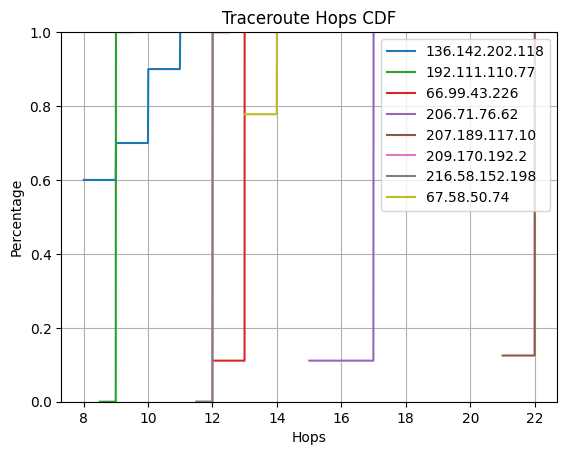

In [28]:
#Traceroute Hops CDF (perfSONAR)
files = ['136_10hr.json', '141_10hr.json', '192_10hr.json', '66_10hr.json', '206_10hr.json', '207_10hr.json', '209_10hr.json', '216_10hr.json', '67_10hr.json']

#files = ['136_10hr.json', '67_10hr.json', '206_10hr.json']

for file in files:
    with open(file, 'r') as f:
        data = json.loads(f.read())

    data_points = 0
    hops = 0
    ttl = 0
    dest = ''

    total_hops = []


    for i in data:
        data_points = data_points + 1
        for item in data[data_points - 1]['val']:
            ttl += 1                                                    #keep track of attempted hops
            if 'rtt' in item:                                           #only sums the completed hops
                hops = hops + 1

        if 'rtt' not in i['val'][ttl-1]:                                #check if trace actually finished
            hops = '*'                                                  #if no rtt, trace didn't finish, so set hops to *
        else:
            dest = i['val'][ttl-1]['ip']                                #store destination to use in graph label

        if hops != '*' :
            total_hops.append(hops)

        hops = 0
        ttl = 0

    #SET DATA TO hops_per_run     
    data = np.array(total_hops)

    #CREATE HISTOGRAM
    count, bins_count = np.histogram(data, bins=300)

    #CALCULATE PDF
    pdf = count / np.sum(count)

    #CALCULATE CDF
    cdf = np.cumsum(pdf)


    #PLOT CDF
    plt.plot(bins_count[1:], cdf, label=dest)

plt.ylim([0,1.0])
plt.title('Traceroute Hops CDF')
plt.ylabel('Percentage')
plt.xlabel('Hops')
plt.grid()
plt.legend()

#ALTHOUGH BINS=300 IN THIS CELL, THE GRAPH WILL NEVER START AT 0 PERCENT DUE TO THE DATA IT CONTAINS
   

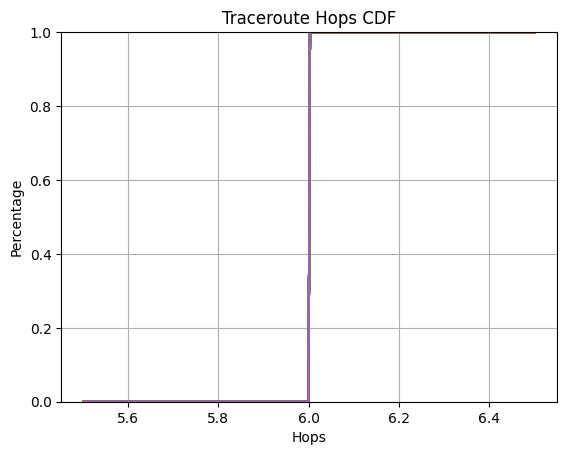

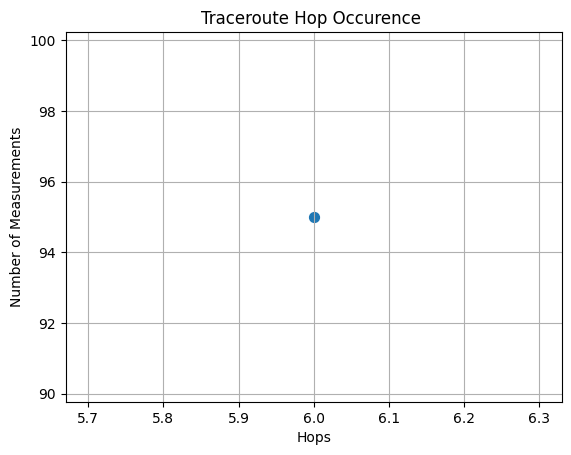

In [29]:
#Traceroute CDF (Perfsonar1 / Leo Version)

import json
import matplotlib.pyplot as plt

with open('192_perf_2daysT_data.json', 'r') as file:
    traceroutes = json.load(file)
num_hops = []
rtt_sum = []
for x in range(0,len(traceroutes)):
    hops = 0
    rtt_total = 0
    for hop in traceroutes[x]['hops']:
        if 'rtt' in hop and 'rtt' != '*':
            rtt_total += hop['rtt']
            hops += 1
    num_hops.append(hops)
    rtt_sum.append(rtt_total)

#SET DATA TO hops_per_run     
    data = np.array(num_hops)

    #CREATE HISTOGRAM
    count, bins_count = np.histogram(data, bins=300)

    #CALCULATE PDF
    pdf = count / np.sum(count)

    #CALCULATE CDF
    cdf = np.cumsum(pdf)


    #PLOT CDF
    plt.plot(bins_count[1:], cdf)

plt.ylim([0,1.0])
plt.title('Traceroute Hops CDF')
plt.ylabel('Percentage')
plt.xlabel('Hops')
plt.grid()
plt.show()

unique_num = []
num_occurence = []
total = 0

for item in num_hops:
    if item not in unique_num:
        unique_num.append(item)

for num in unique_num:
    for item in num_hops:
        if item == num:
            total += 1 
    num_occurence.append(total)        
    total = 0


plt.scatter(x = unique_num, y = num_occurence, s = 50)
plt.title('Traceroute Hop Occurence ')
plt.ylabel('Number of Measurements')
plt.xlabel('Hops')
plt.grid()
plt.show()



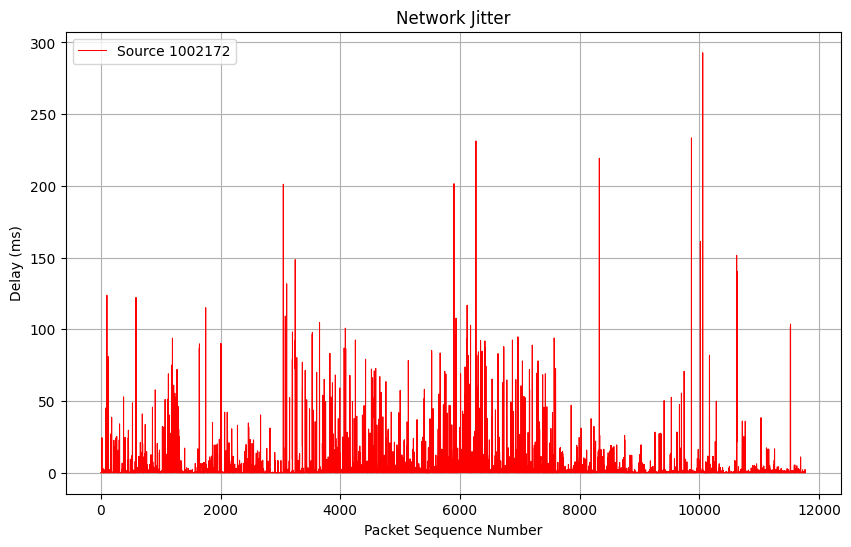

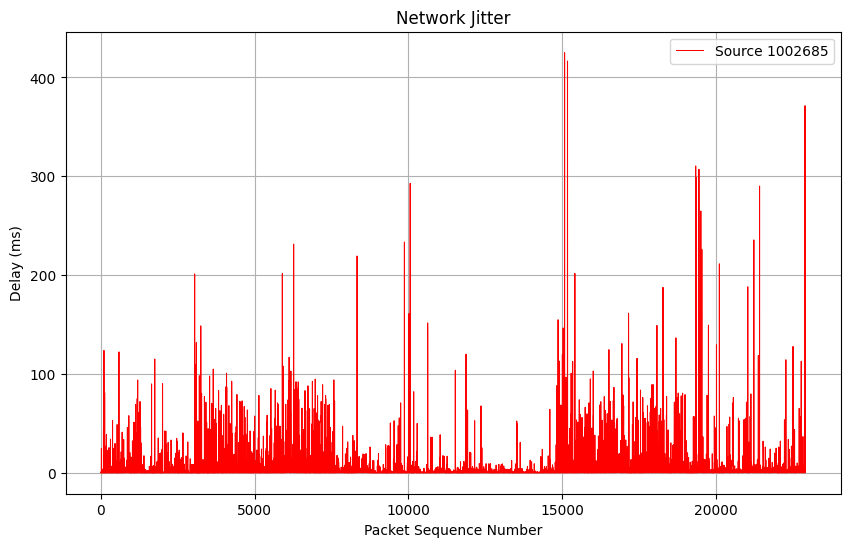

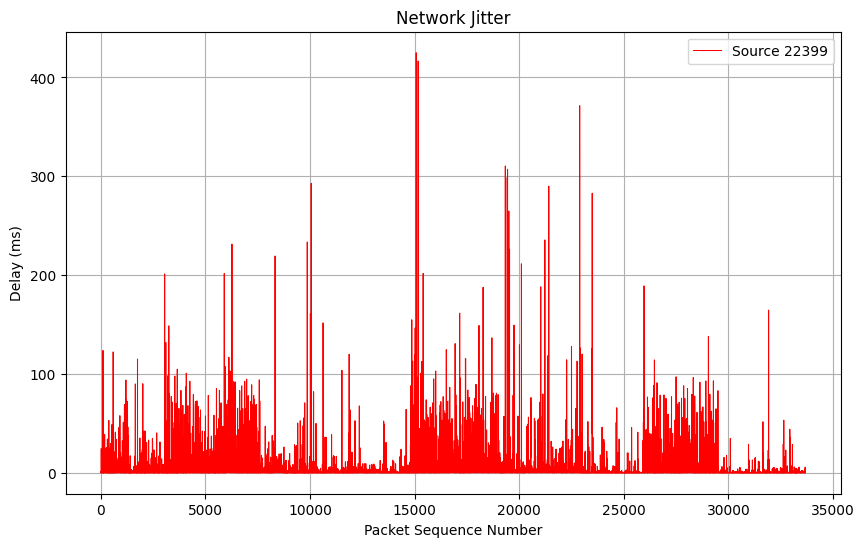

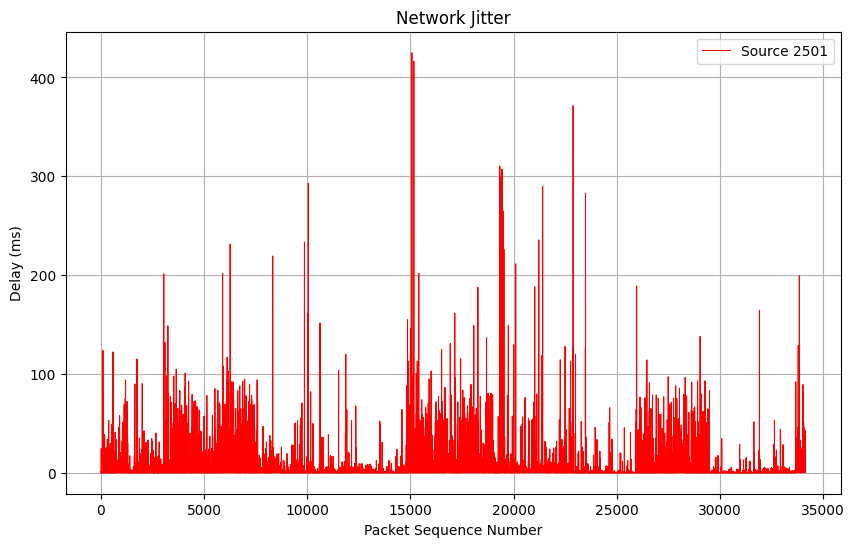

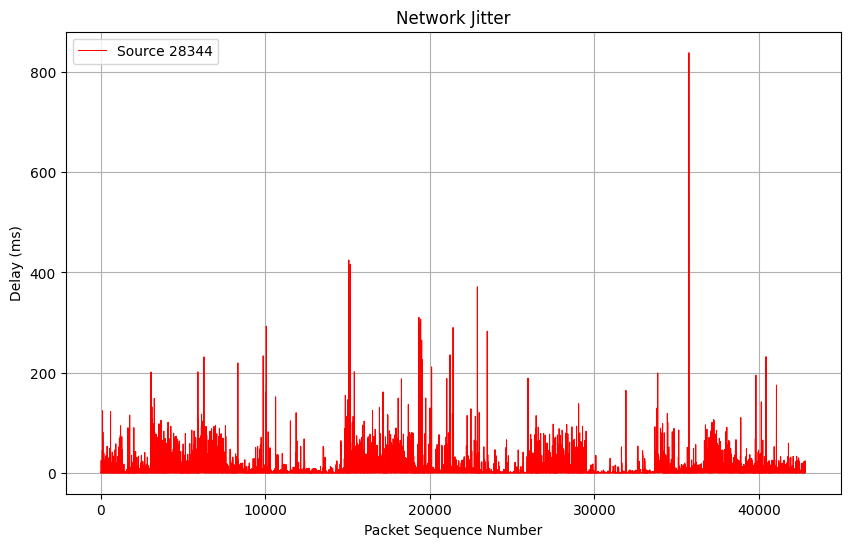

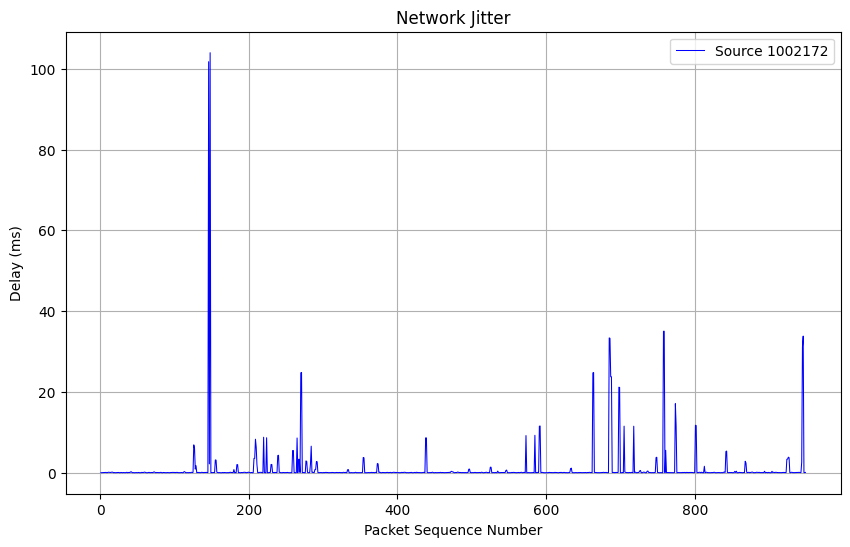

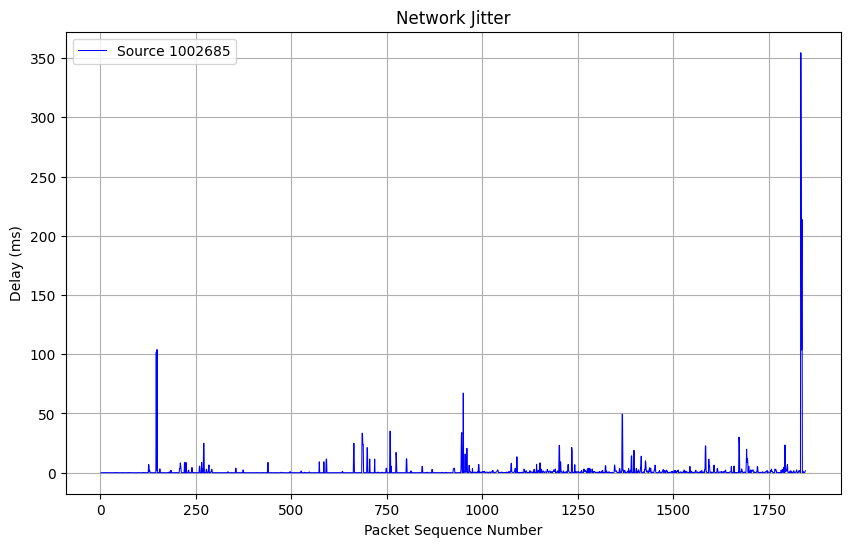

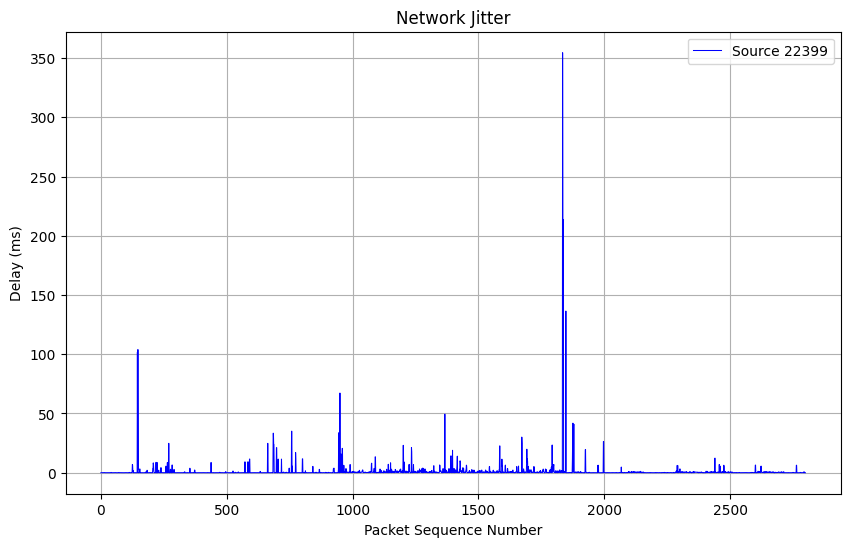

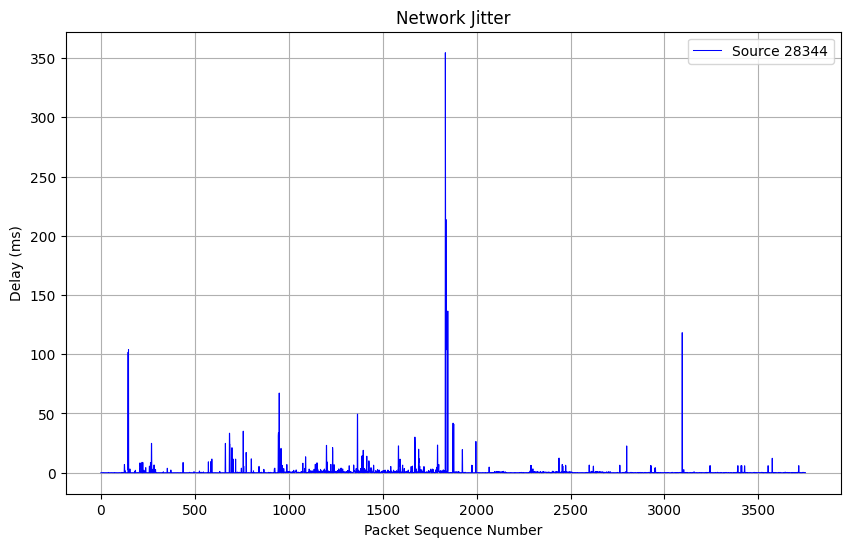

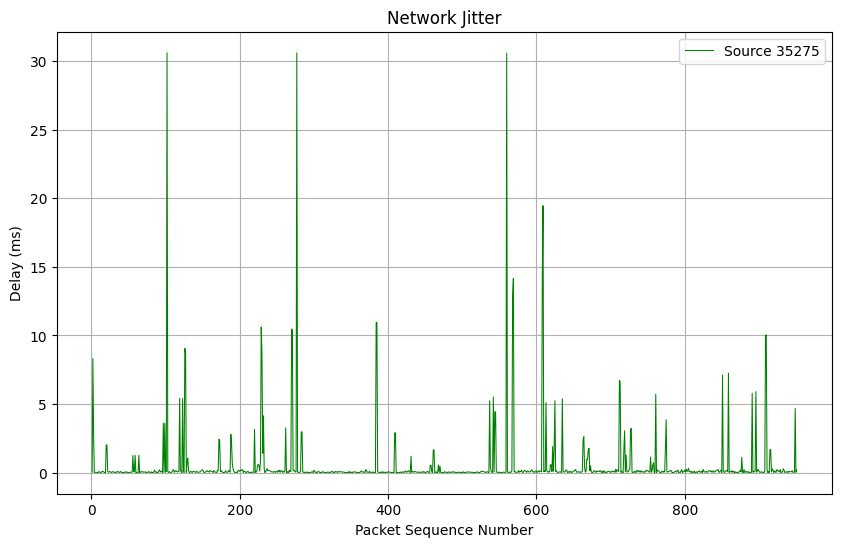

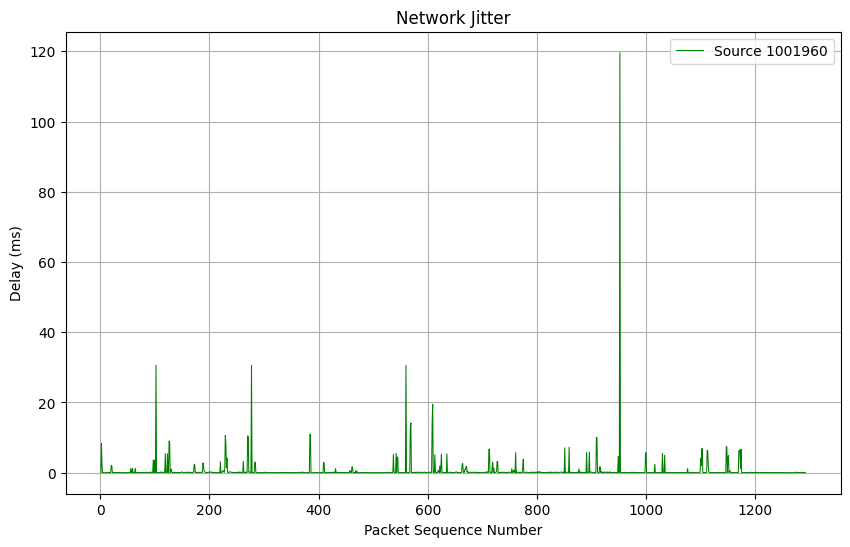

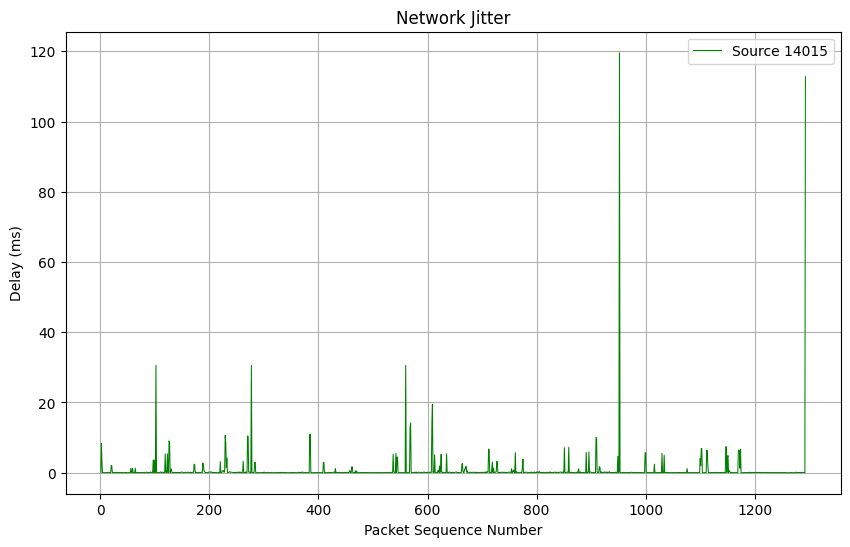

In [30]:
#RIPE Atlas Jitter Graph (works)

measurement_ids = [39019539, 55518153, 55518143]  # Add your desired measurement IDs here

# List of colors for each measurement ID
colors = ['red', 'blue', 'green', 'purple', 'black']  # Add your desired colors here

# Plot the jitter values for each measurement ID
for idx, measurement_id in enumerate(measurement_ids):
    kwargs = {
        "msm_id": measurement_id
    }

    is_success, results = AtlasResultsRequest(**kwargs).create()

    if is_success:
        rtt_values = []
        src_address = []
        for result in results:
            rtt_values.append(result['avg'])
            src_address.append(result['prb_id'])

        # Combine src_address and rtt_values into pairs
        data = list(zip(src_address, rtt_values))

        # Filter out pairs with rtt_value equal to -1
        data = [(src, rtt) for src, rtt in data if rtt != -1]

        # Unzip the filtered data back into separate lists
        src_address, rtt_values = zip(*data)

        #keep track of unique source addresses
        unique = []
        for address in src_address:
            if address not in unique:
                unique.append(address)
        current_data_set = []

        for address in unique:
            for index in range(0, len(src_address)):
                if src_address[index] == address:
                    current_data_set.append(rtt_values[index])
            
            # Calculate the RTT deltas
            rtt_deltas = [abs(current_data_set[i] - current_data_set[i-1]) for i in range(1, len(current_data_set))]

            # Calculate the average RTT delta (jitter)
            jitter = np.sum(rtt_deltas) / len(rtt_deltas)

            # Create a list of timestamps (replace with your actual timestamps)
            timestamps = range(len(current_data_set))


            # Plot the jitter values over time
            plt.figure(figsize=(10, 6))
            plt.plot(timestamps[1:], rtt_deltas, linestyle='-', color=colors[idx], label=f"Source {address}", linewidth=0.75)
            #plt.yscale('log')
            # Set the x-axis label
            plt.xlabel('Packet Sequence Number')

            # Set the y-axis label
            plt.ylabel('Delay (ms)')

            # Set the title
            plt.title('Network Jitter')

            # Display the legend
            plt.legend()

            # Display the grid
            plt.grid(True)


    # Show the plot
    plt.show()


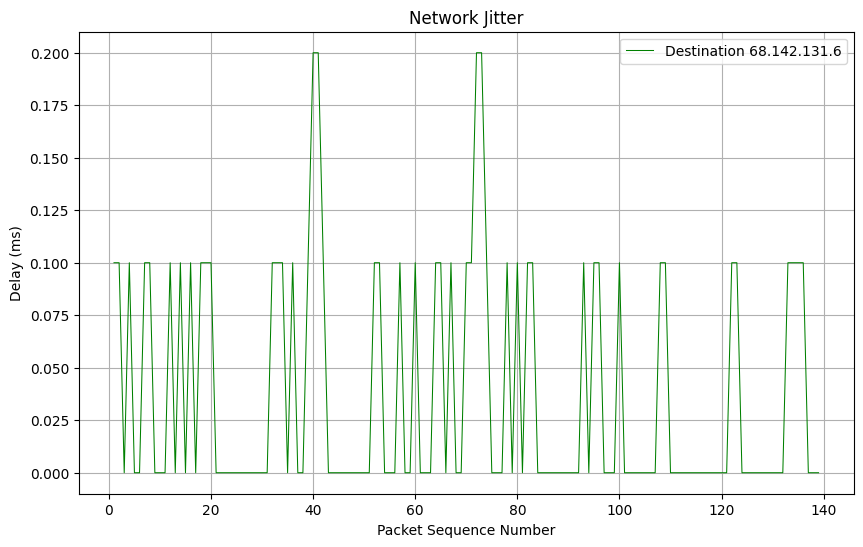

In [31]:
#Command-Line Jitter Graph

import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def plot_ping_jitter(files):
    for file_path in files:
        # Read the JSON file
        with open(file_path, 'r') as f:
            data = json.load(f)

        # Create a DataFrame from the JSON data
        df1 = pd.DataFrame(data)

        # Extract RTT values
        rtt = []
        address = None
        for x, row in df1.iterrows():
            transmissions = df1['ping_data'][x]
            for transmission in transmissions:
                rtt.append(transmission['time'])
                address = transmission['ip_address']

        # Convert RTT to numpy array
        data = np.array(rtt)

        # Compute histogram
        rtt_deltas = [abs(rtt[i] - rtt[i-1]) for i in range(1, len(rtt))]

        # Calculate the average RTT delta (jitter)
        jitter = np.sum(rtt_deltas) / len(rtt_deltas)

        # Create a list of timestamps (replace with your actual timestamps)
        timestamps = range(len(rtt))


        # Plot the jitter values over time
        plt.figure(figsize=(10, 6))
        plt.plot(timestamps[1:], rtt_deltas, linestyle='-', color=colors[idx], label=f"Destination {address}", linewidth=0.75)
        #plt.yscale('log')
        # Set the x-axis label
        plt.xlabel('Packet Sequence Number')

        # Set the y-axis label
        plt.ylabel('Delay (ms)')

        # Set the title
        plt.title('Network Jitter')

        # Display the legend
        plt.legend()

        # Display the grid
        plt.grid(True)


    # Show the plot
    plt.show()

# List of file paths
#files = ['ping_data_66.json', 'ping_data_206.json', 'ping_data_192.json']  # Replace with the actual file paths
#files = ['ping-5days-192.111.110.77-data-leo.json', 'ping-5days-206.71.76.62-data-perf.json', 'ping-5days-206.71.76.62-data-leo.json', 'ping-5days-66.99.43.226-data-perf.json','ping-5days-66.99.43.226-data-leo.json','ping-5days-192.111.110.77-data-perf.json' ]
files = ['pingWTime.json']

# Plot Ping RTT for each file
plot_ping_jitter(files)
